In [39]:
!pip install joypy

In [2]:
import pandas as pd
import seaborn as sns
from joypy import joyplot

In [3]:
df = pd.read_csv("twitter_data.csv")
df.head()

,unit_id,gender,created,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone
0,815719226,male,12/05/13 1:48,i sing my own rhythm.,0,08C2C2,sheezy0,https://pbs.twimg.com/profile_images/414342229096808449/fYvzqXN7_normal.png,0,FFFFFF,Robbie E Responds To Critics After Win Against Eddie Edwards In The #WorldTitleSeries https://t.co/NSybBmVjKZ,NaN,110964,main; @Kan1shk3,Chennai
1,815719227,male,10/01/12 13:51,I'm the author of novels filled with family drama and romance.,68,0084B4,DavdBurnett,https://pbs.twimg.com/profile_images/539604221532700673/WW16tBbU_normal.jpeg,0,C0DEED,‰ÛÏIt felt like they were my friends and I was living the story with them‰Û https://t.co/arngE0YHNO #retired #IAN1 https://t.co/CIzCANPQFz,NaN,7471,NaN,Eastern Time (US & Canada)
2,815719228,male,11/28/14 11:30,louis whining and squealing and all,7696,ABB8C2,lwtprettylaugh,https://pbs.twimg.com/profile_images/657330418249658368/SBLCXdF7_normal.png,1,C0DEED,i absolutely adore when louis starts the songs it hits me hard but it feels good,NaN,5617,clcncl,Belgrade
3,815719229,male,06/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Perkins, Yahoo!, Sprint PCS, AirTouch, Air Force. Stanford GSB, UVa. Dad, Husband, Brother. Golfer.",202,0084B4,douggarland,https://pbs.twimg.com/profile_images/259703936/IMG_8444_normal.JPG,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you use @IFTTT?! Don't typically see an advanced user on the @PGATOUR! https://t.co/H68ou5PE9L,NaN,1693,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,female,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs The Best BAND Xxxx Thank you Kaiser Chiefs for an incredible year of gigs and memories to cherish always :) Xxxxxxx,37318,3B94D9,WilfordGemma,https://pbs.twimg.com/profile_images/564094871032446976/AOfpk-mr_normal.jpeg,0,0,Watching Neighbours on Sky+ catching up with the Neighbs!! Xxx _Ù÷Ä_Ù÷Ä_Ù÷Ä_ÙÔÎ_ÙÈ_ÙÔ_ÙÈ Xxx,NaN,31462,NaN,NaN


In [4]:
df.gender.value_counts(dropna = False) ## fairly distributed, no imbalance

female     6698
male       6192
brand      5942
unknown    1117
NaN          99
Name: gender, dtype: int64

In [5]:
df = df.dropna(subset=['gender'])
df = df[df.gender!="unknown"]
df = df.reset_index(drop=True)

In [6]:
df.gender.value_counts(dropna = False) ## fairly distributed, no imbalance

female    6698
male      6192
brand     5942
Name: gender, dtype: int64

# Gender Prediction

In [7]:
df.columns

Index(['unit_id', 'gender', 'created', 'user_description',
       'user_favourite_number', 'link_color', 'name', 'profileimage',
       'retweet_count', 'sidebar_color', 'tweet_text', 'tweet_coord',
       'tweet_count', 'tweet_location', 'user_timezone'],
      dtype='object')

## Finding Relevant Columns

### unit_id

In [21]:
df.unit_id.nunique(), df.shape[0] ## same, not useful

(20048, 20048)

### user_description and tweet_text

In [85]:
df.user_description.dtype, df.tweet_text.dtype

(dtype('O'), dtype('O'))

Description and tweet_text is a text feature and may be useful to determine the gender. One gender may have a specific writing style, choice of words etc.

### user_favourite_number

In [43]:
df.user_favourite_number.describe() ## user_description)

count     20048.000000
mean       4382.586891
std       12519.139859
min           0.000000
25%          11.000000
50%         456.000000
75%        3316.750000
max      341621.000000
Name: user_favourite_number, dtype: float64

<IPython.core.display.Javascript object>

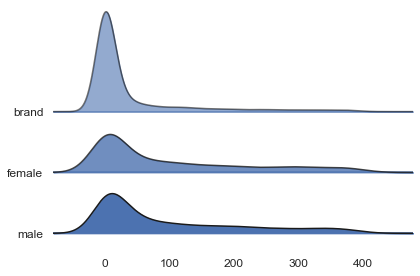

In [71]:
data = df[df.user_favourite_number<400]

joyplot(data, by = 'gender', column = 'user_favourite_number', fade = True)
plt.show()

The distribution appears identical for both gender. Does not hint that user_favourite_number will be an indicator. However, brands have a smaller std dev.

### link_color

In [72]:
link_color_count=df.link_color.value_counts(normalize=True).reset_index()
link_color_count["cumulative"] = 100*link_color_count.link_color.cumsum()
link_color_count

,index,link_color,cumulative
0,0084B4,0.487574,48.757434
1,3B94D9,0.032445,52.001912
2,9999,0.030533,55.055225
3,DD2E44,0.025329,57.588148
4,9266CC,0.024055,59.993628
...,...,...,...
2877,7F785C,0.000053,99.978760
2878,0D318C,0.000053,99.984070
2879,BB2266,0.000053,99.989380
2880,3CB371,0.000053,99.994690


In [73]:
threshold = 70
all_colors = link_color_count[link_color_count.cumulative<threshold]["index"].unique()
pd.pivot_table(df[df.link_color.isin(all_colors)], index=["link_color"], columns=["gender"], values = "unit_id", aggfunc="count", fill_value=0).reset_index()

gender,link_color,brand,female,male
0,0,82,154,147
1,0084B4,3441,2651,3090
2,2FC2EF,65,79,200
3,3B94D9,196,158,257
4,4A913C,160,83,114
5,9266CC,78,283,92
6,9999,171,120,284
7,ABB8C2,70,167,162
8,DD2E44,119,180,178
9,F5ABB5,21,283,40


In [63]:
len(all_colors)

2882

### name

Intuitively, name can determine the gender to some extent.

### profileimage

Unless we retrieve the image and use some computer vision based techniques, a link cannot predict gender.

### retweet_count

<IPython.core.display.Javascript object>

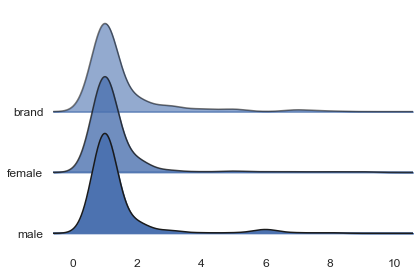

In [83]:
data = df[(df.retweet_count>0) & (df.retweet_count<10)]

joyplot(data, by = 'gender', column = 'retweet_count', fade = True)
plt.show()

Same distribution, retweet_count is likely not an indicator here.

### tweet_coord, tweet_location, user_timezone

Intuitively, it makes no sense that location/timezone can tell gender, let's drop them.

Final features: user_description, tweet_text and name (all text)

## Modeling

### Cleaning

In [8]:
import re
import string
import warnings
warnings.filterwarnings("ignore")

In [9]:
data = df[["user_description", "tweet_text", "name", "gender"]]

In [10]:
# Combine the text columns into a single column
data["text"] = data["user_description"].fillna("") + " " + data["tweet_text"].fillna("") + " " + data["name"].fillna("")

# Convert the text to lowercase
data["text"] = data["text"].str.lower()

# Remove URLs
data["text"] = data["text"].apply(lambda x: re.sub(r'http\S+', '', x))

# Remove hashtags
data["text"] = data["text"].apply(lambda x: re.sub(r'#\w+', '', x))

# Remove mentions
data["text"] = data["text"].apply(lambda x: re.sub(r'@\w+', '', x))

# Remove non-alphanumeric characters
data["text"] = data["text"].apply(lambda x: "".join([char for char in x if char in string.ascii_letters + string.digits + " " + string.punctuation]))

# Drop the original text columns
data = data.drop(["user_description", "tweet_text", "name"], axis=1)

data.head()

,gender,text
0,male,i sing my own rhythm. robbie e responds to critics after win against eddie edwards in the sheezy0
1,male,i'm the author of novels filled with family drama and romance. it felt like they were my friends and i was living the story with them davdburnett
2,male,louis whining and squealing and all i absolutely adore when louis starts the songs it hits me hard but it feels good lwtprettylaugh
3,male,"mobile guy. 49ers, shazam, google, kleiner perkins, yahoo!, sprint pcs, airtouch, air force. stanford gsb, uva. dad, husband, brother. golfer. hi - looking at the url - do you use ?! don't typically see an advanced user on the ! douggarland"
4,female,ricky wilson the best frontman/kaiser chiefs the best band xxxx thank you kaiser chiefs for an incredible year of gigs and memories to cherish always :) xxxxxxx watching neighbours on sky+ catching up with the neighbs!! xxx _______ xxx wilfordgemma


### Count Vectorizer + Naive Bayes

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [12]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["gender"], test_size=0.1)

# Create a count vectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train = vectorizer.fit_transform(X_train)

# Transform the test data
X_test = vectorizer.transform(X_test)

# Train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Calculate the test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Make predictions on the training data
y_pred_train = classifier.predict(X_train)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

## Not generalizing well

Train accuracy: 0.8740854378097711
Test accuracy: 0.6491507430997877


### TFIDF Vectorizer + Naive Bayes

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [134]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["gender"], test_size=0.1, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = vectorizer.fit_transform(X_train)

# Transform the test data
X_test = vectorizer.transform(X_test)

# Train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Calculate the test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Make predictions on the training data
y_pred_train = classifier.predict(X_train)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

## Still kind of overfitting

Train accuracy: 0.8445834316733538
Test accuracy: 0.6353503184713376


### Count Vectorizer + Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

In [142]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["gender"], test_size=0.2)

# Create a count vectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train = vectorizer.fit_transform(X_train)

# Transform the test data
X_test = vectorizer.transform(X_test)

# Train a Multinomial Naive Bayes classifier
classifier = LogisticRegression(max_iter=100)
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Calculate the test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Make predictions on the training data
y_pred_train = classifier.predict(X_train)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

## High overfitting

Train accuracy: 0.9902422834384335
Test accuracy: 0.6214494292540483


### Count Vectorizer + Logistic Regression + regularization

In [8]:
from sklearn.linear_model import LogisticRegression

In [40]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["gender"], test_size=0.2)

# Create a count vectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train = vectorizer.fit_transform(X_train)

# Transform the test data
X_test = vectorizer.transform(X_test)

# Train a Multinomial Naive Bayes classifier
classifier = LogisticRegression(max_iter=100, C = 0.01)
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Calculate the test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Make predictions on the training data
y_pred_train = classifier.predict(X_train)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

## High overfitting

Train accuracy: 0.6982409558579489
Test accuracy: 0.6063180249535439


### TFIDF Vectorizer + Logistic Regression

In [143]:
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["gender"], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = vectorizer.fit_transform(X_train)

# Transform the test data
X_test = vectorizer.transform(X_test)

# Train a logistic regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Calculate the test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Make predictions on the training data
y_pred_train = classifier.predict(X_train)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

Train accuracy: 0.875472950547627
Test accuracy: 0.6331298115211044


### TFIDF Vectorizer + SVM

In [144]:
from sklearn.svm import SVC

In [145]:
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["gender"], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = vectorizer.fit_transform(X_train)

# Transform the test data
X_test = vectorizer.transform(X_test)

# Train an SVM classifier
classifier = SVC(kernel='linear', C=1)
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Calculate the test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Make predictions on the training data
y_pred_train = classifier.predict(X_train)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

## Overfitting

Train accuracy: 0.8987719880517756
Test accuracy: 0.635518980621184


### Random Forest

In [146]:
from sklearn.ensemble import RandomForestClassifier

In [156]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["gender"], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = vectorizer.fit_transform(X_train)

# Transform the test data
X_test = vectorizer.transform(X_test)

# Train a random forest classifier
classifier = RandomForestClassifier(n_estimators=20, random_state=42, max_depth = 35)
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Calculate the test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Make predictions on the training data
y_pred_train = classifier.predict(X_train)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

Train accuracy: 0.7666777298373714
Test accuracy: 0.5553490841518449


### Gradient Boosting

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

In [54]:
# Define the features and target variable
X = data["text"]
y = data["gender"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
X_train_vect = vectorizer.fit_transform(X_train)

# Define the gradient boosting classifier
gb_clf = GradientBoostingClassifier()

# Train the classifier on the training data
gb_clf.fit(X_train_vect, y_train)

# Transform the test data using the vectorizer
X_test_vect = vectorizer.transform(X_test)

# Make predictions on the test data
y_pred = gb_clf.predict(X_test_vect)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print("Test accuracy:", accuracy)


Test accuracy: 0.5856118927528537


## Final Model -- Count Vectorizer + Naive Bayes

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [18]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["gender"], test_size=0.1)

# Create a count vectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train = vectorizer.fit_transform(X_train)

# Transform the test data
X_test = vectorizer.transform(X_test)

# Train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Calculate the test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Make predictions on the training data
y_pred_train = classifier.predict(X_train)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

Train accuracy: 0.8746164739202266
Test accuracy: 0.6395966029723992


## Analysis

### Predict gender using model

In [19]:
# Combine the text columns into a single column
df["text"] = df["user_description"].fillna("") + " " + df["tweet_text"].fillna("") + " " + df["name"].fillna("")

# Convert the text to lowercase
df["text"] = df["text"].str.lower()

# Remove URLs
df["text"] = df["text"].apply(lambda x: re.sub(r'http\S+', '', x))

# Remove hashtags
df["text"] = df["text"].apply(lambda x: re.sub(r'#\w+', '', x))

# Remove mentions
df["text"] = df["text"].apply(lambda x: re.sub(r'@\w+', '', x))

# Remove non-alphanumeric characters
df["text"] = df["text"].apply(lambda x: "".join([char for char in x if char in string.ascii_letters + string.digits + " " + string.punctuation]))

# Drop the original text columns
df.head()

,unit_id,gender,created,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,text,predicted_gender
0,815719226,male,12/05/13 1:48,i sing my own rhythm.,0,08C2C2,sheezy0,https://pbs.twimg.com/profile_images/414342229096808449/fYvzqXN7_normal.png,0,FFFFFF,Robbie E Responds To Critics After Win Against Eddie Edwards In The #WorldTitleSeries https://t.co/NSybBmVjKZ,NaN,110964,main; @Kan1shk3,Chennai,i sing my own rhythm. robbie e responds to critics after win against eddie edwards in the sheezy0,male
1,815719227,male,10/01/12 13:51,I'm the author of novels filled with family drama and romance.,68,0084B4,DavdBurnett,https://pbs.twimg.com/profile_images/539604221532700673/WW16tBbU_normal.jpeg,0,C0DEED,‰ÛÏIt felt like they were my friends and I was living the story with them‰Û https://t.co/arngE0YHNO #retired #IAN1 https://t.co/CIzCANPQFz,NaN,7471,NaN,Eastern Time (US & Canada),i'm the author of novels filled with family drama and romance. it felt like they were my friends and i was living the story with them davdburnett,female
2,815719228,male,11/28/14 11:30,louis whining and squealing and all,7696,ABB8C2,lwtprettylaugh,https://pbs.twimg.com/profile_images/657330418249658368/SBLCXdF7_normal.png,1,C0DEED,i absolutely adore when louis starts the songs it hits me hard but it feels good,NaN,5617,clcncl,Belgrade,louis whining and squealing and all i absolutely adore when louis starts the songs it hits me hard but it feels good lwtprettylaugh,male
3,815719229,male,06/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Perkins, Yahoo!, Sprint PCS, AirTouch, Air Force. Stanford GSB, UVa. Dad, Husband, Brother. Golfer.",202,0084B4,douggarland,https://pbs.twimg.com/profile_images/259703936/IMG_8444_normal.JPG,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you use @IFTTT?! Don't typically see an advanced user on the @PGATOUR! https://t.co/H68ou5PE9L,NaN,1693,"Palo Alto, CA",Pacific Time (US & Canada),"mobile guy. 49ers, shazam, google, kleiner perkins, yahoo!, sprint pcs, airtouch, air force. stanford gsb, uva. dad, husband, brother. golfer. hi - looking at the url - do you use ?! don't typically see an advanced user on the ! douggarland",male
4,815719230,female,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs The Best BAND Xxxx Thank you Kaiser Chiefs for an incredible year of gigs and memories to cherish always :) Xxxxxxx,37318,3B94D9,WilfordGemma,https://pbs.twimg.com/profile_images/564094871032446976/AOfpk-mr_normal.jpeg,0,0,Watching Neighbours on Sky+ catching up with the Neighbs!! Xxx _Ù÷Ä_Ù÷Ä_Ù÷Ä_ÙÔÎ_ÙÈ_ÙÔ_ÙÈ Xxx,NaN,31462,NaN,NaN,ricky wilson the best frontman/kaiser chiefs the best band xxxx thank you kaiser chiefs for an incredible year of gigs and memories to cherish always :) xxxxxxx watching neighbours on sky+ catching up with the neighbs!! xxx _______ xxx wilfordgemma,female


In [20]:
text_features = vectorizer.transform(df["text"])

In [21]:
df["predicted_gender"] = classifier.predict(text_features)

In [22]:
df.predicted_gender.value_counts()

female    7735
male      5892
brand     5205
Name: predicted_gender, dtype: int64

In [23]:
## remove some columns

df = df.drop(columns = ["text", "profileimage", "retweet_count", "sidebar_color", "created"])

In [24]:
df.head()

,unit_id,gender,user_description,user_favourite_number,link_color,name,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,predicted_gender
0,815719226,male,i sing my own rhythm.,0,08C2C2,sheezy0,Robbie E Responds To Critics After Win Against Eddie Edwards In The #WorldTitleSeries https://t.co/NSybBmVjKZ,NaN,110964,main; @Kan1shk3,Chennai,male
1,815719227,male,I'm the author of novels filled with family drama and romance.,68,0084B4,DavdBurnett,‰ÛÏIt felt like they were my friends and I was living the story with them‰Û https://t.co/arngE0YHNO #retired #IAN1 https://t.co/CIzCANPQFz,NaN,7471,NaN,Eastern Time (US & Canada),female
2,815719228,male,louis whining and squealing and all,7696,ABB8C2,lwtprettylaugh,i absolutely adore when louis starts the songs it hits me hard but it feels good,NaN,5617,clcncl,Belgrade,male
3,815719229,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Perkins, Yahoo!, Sprint PCS, AirTouch, Air Force. Stanford GSB, UVa. Dad, Husband, Brother. Golfer.",202,0084B4,douggarland,Hi @JordanSpieth - Looking at the url - do you use @IFTTT?! Don't typically see an advanced user on the @PGATOUR! https://t.co/H68ou5PE9L,NaN,1693,"Palo Alto, CA",Pacific Time (US & Canada),male
4,815719230,female,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs The Best BAND Xxxx Thank you Kaiser Chiefs for an incredible year of gigs and memories to cherish always :) Xxxxxxx,37318,3B94D9,WilfordGemma,Watching Neighbours on Sky+ catching up with the Neighbs!! Xxx _Ù÷Ä_Ù÷Ä_Ù÷Ä_ÙÔÎ_ÙÈ_ÙÔ_ÙÈ Xxx,NaN,31462,NaN,NaN,female


### Extract mentions and links from tweet

In [25]:
# Define a function to extract mentions from a tweet text
def extract_mentions(text):
    mentions = re.findall(r'@([a-zA-Z0-9_]+)', text)
    return mentions

# Define a function to extract links from a tweet text
def extract_links(text):
    links = re.findall(r'(https?://\S+)', text)
    return links

# Apply the extract_mentions function to the tweet_text column and create a new column with the results
df['mentions'] = df['tweet_text'].apply(lambda x: extract_mentions(x))

# Apply the extract_links function to the tweet_text column and create a new column with the results
df['links'] = df['tweet_text'].apply(lambda x: extract_links(x))

df.head()

,unit_id,gender,user_description,user_favourite_number,link_color,name,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,predicted_gender,mentions,links
0,815719226,male,i sing my own rhythm.,0,08C2C2,sheezy0,Robbie E Responds To Critics After Win Against Eddie Edwards In The #WorldTitleSeries https://t.co/NSybBmVjKZ,NaN,110964,main; @Kan1shk3,Chennai,male,[],[https://t.co/NSybBmVjKZ]
1,815719227,male,I'm the author of novels filled with family drama and romance.,68,0084B4,DavdBurnett,‰ÛÏIt felt like they were my friends and I was living the story with them‰Û https://t.co/arngE0YHNO #retired #IAN1 https://t.co/CIzCANPQFz,NaN,7471,NaN,Eastern Time (US & Canada),female,[],"[https://t.co/arngE0YHNO, https://t.co/CIzCANPQFz]"
2,815719228,male,louis whining and squealing and all,7696,ABB8C2,lwtprettylaugh,i absolutely adore when louis starts the songs it hits me hard but it feels good,NaN,5617,clcncl,Belgrade,male,[],[]
3,815719229,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Perkins, Yahoo!, Sprint PCS, AirTouch, Air Force. Stanford GSB, UVa. Dad, Husband, Brother. Golfer.",202,0084B4,douggarland,Hi @JordanSpieth - Looking at the url - do you use @IFTTT?! Don't typically see an advanced user on the @PGATOUR! https://t.co/H68ou5PE9L,NaN,1693,"Palo Alto, CA",Pacific Time (US & Canada),male,"[JordanSpieth, IFTTT, PGATOUR]",[https://t.co/H68ou5PE9L]
4,815719230,female,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs The Best BAND Xxxx Thank you Kaiser Chiefs for an incredible year of gigs and memories to cherish always :) Xxxxxxx,37318,3B94D9,WilfordGemma,Watching Neighbours on Sky+ catching up with the Neighbs!! Xxx _Ù÷Ä_Ù÷Ä_Ù÷Ä_ÙÔÎ_ÙÈ_ÙÔ_ÙÈ Xxx,NaN,31462,NaN,NaN,female,[],[]


In [26]:
gender_interact_df = df[["predicted_gender", "mentions", "links"]].explode("mentions").explode("links")
gender_interact_df = gender_interact_df[gender_interact_df.predicted_gender != "brand"]
gender_interact_df = gender_interact_df.reset_index(drop = True)
gender_interact_df

,predicted_gender,mentions,links
0,male,NaN,https://t.co/NSybBmVjKZ
1,female,NaN,https://t.co/arngE0YHNO
2,female,NaN,https://t.co/CIzCANPQFz
3,male,NaN,NaN
4,male,JordanSpieth,https://t.co/H68ou5PE9L
...,...,...,...
15738,male,oguzbilgic,NaN
15739,male,EmojiProposals,NaN
15740,female,NaN,NaN
15741,male,NaN,https://t.co/tYIf6bZmX2


### Gender-wise mentions

In [27]:
gender_mention_crosstab = pd.crosstab(gender_interact_df.mentions, gender_interact_df.predicted_gender)
gender_mention_crosstab["total"] = gender_mention_crosstab.male + gender_mention_crosstab.female
gender_mention_crosstab = gender_mention_crosstab.sort_values("total", ascending = False)
gender_mention_crosstab["%female"] = round(100*gender_mention_crosstab.female/gender_mention_crosstab.total,2)
gender_mention_crosstab["%male"] = round(100*gender_mention_crosstab.male/gender_mention_crosstab.total,2)

gender_mention_crosstab

predicted_gender,female,male,total,%female,%male
mentions,,,,,
onedirection,81,38,119,68.07,31.93
Harry_Styles,100,10,110,90.91,9.09
YouTube,15,39,54,27.78,72.22
justinbieber,26,4,30,86.67,13.33
NBA,2,12,14,14.29,85.71
...,...,...,...,...,...
Miss_Saraix3,1,0,1,100.00,0.00
MissPosey,1,0,1,100.00,0.00
MissImm0rtal,1,0,1,100.00,0.00


### Gender-wise links

In [29]:
gender_links_crosstab = pd.crosstab(gender_interact_df.links, gender_interact_df.predicted_gender)
gender_links_crosstab["total"] = gender_links_crosstab.male + gender_links_crosstab.female
gender_links_crosstab = gender_links_crosstab.sort_values("total", ascending = False)
gender_links_crosstab["%female"] = round(100*gender_links_crosstab.female/gender_links_crosstab.total,2)
gender_links_crosstab["%male"] = round(100*gender_links_crosstab.male/gender_links_crosstab.total,2)

gender_links_crosstab

predicted_gender,female,male,total,%female,%male
links,,,,,
https://t.co/bFbEXh0EFX,8,0,8,100.0,0.0
https://t.co/Ry5vuYxWO5,7,0,7,100.0,0.0
https://t.co/5IV46WvPMc,0,7,7,0.0,100.0
https://t.co/2NVaB7JGEm,0,7,7,0.0,100.0
https://t.co/m0b5CYWJsz,0,6,6,0.0,100.0
...,...,...,...,...,...
https://t.co/L5O2anZGgQ,0,1,1,0.0,100.0
https://t.co/L9kO63RNmS,1,0,1,100.0,0.0
https://t.co/LA5nKzw5jy,1,0,1,100.0,0.0


### Location-wise links

In [30]:
df.tweet_coord.isna().sum()/df.shape[0] ## High missing rate

0.9916631265930331

In [31]:
df.tweet_location.isna().sum()/df.shape[0] ## Fair miss rate

0.3632646559048428

In [32]:
df.user_timezone.isna().sum()/df.shape[0] ## Fair miss rate

0.3814252336448598

In [37]:
location_interact_df = df[["tweet_location", "user_timezone", "mentions", "links"]].explode("mentions").explode("links")
location_interact_df = location_interact_df.reset_index(drop = True)
location_interact_df

,tweet_location,user_timezone,mentions,links
0,main; @Kan1shk3,Chennai,NaN,https://t.co/NSybBmVjKZ
1,NaN,Eastern Time (US & Canada),NaN,https://t.co/arngE0YHNO
2,NaN,Eastern Time (US & Canada),NaN,https://t.co/CIzCANPQFz
3,clcncl,Belgrade,NaN,NaN
4,"Palo Alto, CA",Pacific Time (US & Canada),JordanSpieth,https://t.co/H68ou5PE9L
...,...,...,...,...
22125,"Miami, FL",Eastern Time (US & Canada),HomemadeDelish,https://t.co/YtmiRfmoLp
22126,"Miami, FL",Eastern Time (US & Canada),HomemadeDelish,https://t.co/tuMsFceTlG
22127,"Miami, FL",Eastern Time (US & Canada),MenageaTrois,https://t.co/YtmiRfmoLp
22128,"Miami, FL",Eastern Time (US & Canada),MenageaTrois,https://t.co/tuMsFceTlG


In [38]:
location_interact_df_tzone = location_interact_df[~location_interact_df.user_timezone.isna()].reset_index(drop=True)
location_interact_df_tzone

,tweet_location,user_timezone,mentions,links
0,main; @Kan1shk3,Chennai,NaN,https://t.co/NSybBmVjKZ
1,NaN,Eastern Time (US & Canada),NaN,https://t.co/arngE0YHNO
2,NaN,Eastern Time (US & Canada),NaN,https://t.co/CIzCANPQFz
3,clcncl,Belgrade,NaN,NaN
4,"Palo Alto, CA",Pacific Time (US & Canada),JordanSpieth,https://t.co/H68ou5PE9L
...,...,...,...,...
13769,"Miami, FL",Eastern Time (US & Canada),deathsdoor,https://t.co/tuMsFceTlG
13770,"Miami, FL",Eastern Time (US & Canada),HomemadeDelish,https://t.co/YtmiRfmoLp
13771,"Miami, FL",Eastern Time (US & Canada),HomemadeDelish,https://t.co/tuMsFceTlG
13772,"Miami, FL",Eastern Time (US & Canada),MenageaTrois,https://t.co/YtmiRfmoLp


In [40]:
location_mentions_crosstab = pd.crosstab(location_interact_df_tzone.user_timezone, location_interact_df_tzone.mentions)
location_mentions_crosstab

mentions,007,00Sev,10000buddhas,1000kindsofrain,101Best,1057thePoint,10thMar1905,1102boomsoon,11Freeman11,11thHourQuest,...,yungsea_,zaynmalik,zeemills,zerkaahd,zerofiltertruth,zerohedge,ziajojo,zodiacforest,zoej98,zoey02619
user_timezone,,,,,,,,,,,,,,,,,,,,,
Abu Dhabi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adelaide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Africa/Lagos,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Africa/Nairobi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alaska,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wellington,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
West Central Africa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Yakutsk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
location_mentions_crosstab.sum().sort_values()

mentions
zoey02619           1
avi_machina         1
aweesan             1
awesomeknight69     1
awinehouse1         1
                   ..
lottietommo        13
justinbieber       23
onedirection       51
YouTube            54
Harry_Styles       97
Length: 4879, dtype: int64

In [41]:
location_links_crosstab = pd.crosstab(location_interact_df_tzone.user_timezone, location_interact_df_tzone.links)
location_links_crosstab

links,http://videosmusicalesdelaaeg.blogspot.com/,https://t.co/0057BOWKey,https://t.co/00Y1AU3V3p,https://t.co/00ZAue0wBk,https://t.co/00iRccrRHB,https://t.co/01iUBj2Hqu,https://t.co/02uImdySZj,https://t.co/035xGKwj5d,https://t.co/04fRpMTNVk,https://t.co/04qKhSCowl,...,https://t.co/zuernrA6nE,https://t.co/zuhl6LKdjt,https://t.co/zuuqPSHo6O,https://t.co/zvQVCSWNgV,https://t.co/zxKMQT1UA5,https://t.co/zyCaD9luLE,https://t.co/zyEgiBBlUV,https://t.co/zzcHZ7Ufvo,https://t.co/zzv9NM6hGW,https://t.co/zzyjF6dL0x
user_timezone,,,,,,,,,,,,,,,,,,,,,
Abu Dhabi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adelaide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Africa/Cairo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Africa/Lagos,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alaska,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wellington,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
West Central Africa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Yakutsk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
location_links_crosstab.sum().sort_values()

links
http://videosmusicalesdelaaeg.blogspot.com/     1
https://t.co/eUCGj9sjxk                         1
https://t.co/eTV6HOY9mM                         1
https://t.co/eRY4ZpDJdD                         1
https://t.co/eRKIf52mYu                         1
                                               ..
https://t.co/tuMsFceTlG                         8
https://t.co/bFbEXh0EFX                         8
https://t.co/YtmiRfmoLp                         8
https://t.co/o0FV24HDt0                        10
https://t.co/LA4XWa72eW                        10
Length: 5206, dtype: int64